In [1]:
import networkx as nx # library to handle graphs
import matplotlib.pyplot as plt # library to plot things
import numpy as np # library for maths
from networkx.drawing.nx_agraph import graphviz_layout

## CLIQUES algorithm:

Implementation of the algorithm CLIQUES from Fig. 2 of E. Tomita, A. Tanaka, and H. Takahashi. The worst-case time complexity for generating all maximal cliques and computational experiments. Theor. Comput. Sci., 363(1):28–42, October 2006.

https://snap.stanford.edu/class/cs224w-readings/tomita06cliques.pdf

In [2]:
def intersection(sets):
    """
    given a list of sets (each set is a list of nodes),
    return a list of the nodes that are in all of the sets.
    """
    return list(set.intersection(*map(set, sets)))

def exclusion(A, B):
    """
    returns the set of nodes A without any of the nodes in B.
    """
    try:
        excluded = [x for x in A if x not in B]
    except:
        excluded = [x for x in A if x != B]
    return excluded

def largestVertex(G, SUBG, CAND):
    """
    returns the node v in SUBG that maximizes 
    |CAND (intersection symbol) neighborhood of v|.
    """
    intersectionLengths = []
    for node in SUBG:
        intersectionLengths.append( len( intersection( [list(G.neighbors(node)), list(CAND.nodes())] ) ) )
    index = np.where( intersectionLengths==np.max(intersectionLengths) )
    return list(SUBG.nodes())[index[0][0]]

def EXPAND(G,SUBG,CAND,L):
    """
    the procedure EXPAND 
    given in Fig.2 of the paper.
    """
    if len(list(SUBG.nodes())) == 0:
        print( "CLIQUE!" )
        L.append('clique')
    else:
        u = largestVertex(G, SUBG, CAND)
        while len( exclusion(list(CAND.nodes()), list(G.neighbors(u)) )) != 0:
            previous_node = ["ROOT"]
            q = list(CAND.subgraph( exclusion(list(CAND.nodes()), list(G.neighbors(u)))).nodes())[0]
            print( q, end="," )
            L.append(q)
            SUBGq = SUBG.subgraph( intersection([list(SUBG.nodes()), list(G.neighbors(q))]) )
            CANDq = CAND.subgraph( intersection([list(CAND.nodes()), list(G.neighbors(q))]) )
            EXPAND(G,SUBGq,CANDq,L)
            CAND = CAND.subgraph( exclusion(list(CAND.nodes()), q) )
            print( "back", end=',' )
            L.append('back')
            
def CLIQUES(G):
    L = list()
    """
    the CLIQUES algorithm.
    """
    EXPAND(G,G,G,L)
    print( 'finished.')
    return L

def preprocess(G):
    """
    enumerate all wedges in G
    """
    wedges = dict()
    for i in list(G.nodes()):
        wedges_i = []
        for j in list(G.nodes()):
            if i!=j:
                wedges_from_j = [x for x in list( nx.all_simple_paths(G,j,i,2)) if (len(x)==3)]
                for w in wedges_from_j:
                    if w !=[]:
                        wedges_i.append(w)
        wedges[i] = wedges_i
    return wedges

def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):
    
    """
    basic tree plot function lifted off github
    """
    
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')
    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))
    def _hierarchy_pos(G, root, width=.8, vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

def formatCliquesList(L):
    """
    the CLIQUES algorithm outputs a useless string of code.
    This function formats that into a nice user-friendly list.
    """
    newList = []
    for i in range(len(L)):
        if (L[i]!='clique'):
            if L[i]!='back':
                newList.append(L[i])
            else:
                xx = 0
                rest = L[i:]
                for x in range(len(rest)):
                    if rest[x]=='back':
                        xx += 1
                    if rest[x]!='back':
                        break
                newList.append(str(xx))
    fmtList = [newList[x] for x in range(len(newList)-1) if (not isinstance(newList[x],str)) or (not isinstance(newList[x-1],str))]
    return fmtList

def createTree(List):
    """
    creates a networkx tree from the (formatted) list output by the CLIQUES algorithm.
    """
    tree = nx.DiGraph()
    tree.add_node(0, value="ROOT")
    previousNodes = [0]
    lastNode = 0
    labels = {0:"ROOT"}
    for i in range(len(List)):
        if not isinstance(List[i], str):
            labels[i+1] = List[i]
            tree.add_node(i+1, value=List[i])
            tree.add_edge(lastNode, i+1)
            try:
                if isinstance(List[i+1], str):
                    shift = -int(List[i+1])+1
                    if shift<0:
                        previousNodes = previousNodes[:shift]
                    lastNode = previousNodes[-1]
                else:
                    lastNode = i+1
                    previousNodes.append(i+1)
            except:
                lastNode = i+1
                previousNodes.append(i+1)
        else:
            pass
    pos = hierarchy_pos(tree,0)
    return tree, pos, labels


## A toy example:

Create some graph with a few cliques:

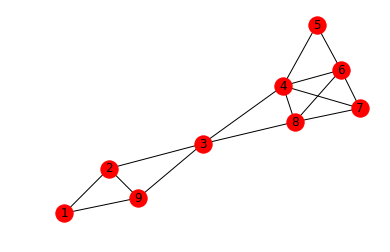

In [3]:
G = nx.Graph() # instantiate a graph object

G.add_nodes_from([1,2,3,4,5,6,7,8,9]) # add some nodes

G.add_edges_from([(1,9), (1,2), (9,2), (9,3), (2,3), (8,3), (3,4),
                 (8,4), (8,6), (8,7), (7,6), (6,4), (6,5), (4,5), (4,7)])  # add edges between some nodes

labels = nx.draw_networkx(G, pos=nx.spring_layout(G)) # draw the graph with labels
plt.axis('off')
plt.show() # show the plot

The cliques algorithm works its magic. The collection of nodes from on any path from root node to leaf is a maximal clique.

1,9,2,CLIQUE!
back,back,back,9,3,2,CLIQUE!
back,back,back,2,back,4,3,8,CLIQUE!
back,back,6,8,7,CLIQUE!
back,back,5,CLIQUE!
back,back,back,finished.


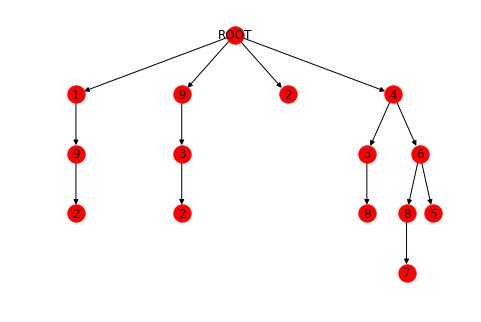

In [6]:
L = formatCliquesList(CLIQUES(G))
tree, pos, labels = createTree(L)
nx.draw(tree, pos=pos, labels=labels, with_labels=True)
plt.show()